In [3]:
import gensim
from gensim.models import KeyedVectors
from gensim.models.fasttext import FastText as FT_gensim
import pandas as pd
import numpy as np
import pickle
from wiki import Wiki,Revision
%matplotlib inline

In [4]:
def get_word_vecs(wiki_vec, tokens):
    in_vocab_tokens = set(tokens) & set(wiki_vec.vocab)
    if in_vocab_tokens:
        return wiki_vec[in_vocab_tokens].sum(axis=0, keepdims=True)
    else:
        return np.zeros((1, wiki_vec.vector_size))

In [5]:
wiki_vec = KeyedVectors.load_word2vec_format('../wordvectors/wiki.en.vec', binary=False, limit=5000)

### reading the change object and clustering.

In [6]:
%%time
content = "Violence_against_Muslims_in_India"
with open(content+".pkl", "rb") as file:
    wiki = pickle.load(file)

CPU times: user 4.87 s, sys: 10.1 s, total: 14.9 s
Wall time: 15 s


In [32]:
%%time
change_objects = []
wiki.revisions.iloc[:-1].apply(lambda revision: change_objects.append(revision.neighbour))
change_index = [ (rev.editor, rev.timestamp) for rev in  wiki.revisions[:-1].values.ravel().tolist()]
change_df = pd.concat(change_objects, sort=False, keys=change_index, names=["editor", "timestamp", "id"])


CPU times: user 228 ms, sys: 20 ms, total: 248 ms
Wall time: 248 ms


In [12]:
%%time
ins_vec_list = []
change_df["ins_tokens"].apply(lambda token_set: ins_vec_list.append(get_word_vecs(wiki_vec, token_set)))
ins_matrix = np.concatenate(ins_vec_list, axis=0)

del_vec_list = []
change_df["del_tokens"].apply(lambda token_set: del_vec_list.append(get_word_vecs(wiki_vec, token_set)))
del_matrix = np.concatenate(del_vec_list, axis=0)

left_vec_list = []
change_df["left_token"].apply(lambda token_set: left_vec_list.append(get_word_vecs(wiki_vec, token_set)))
left_neighbour_matrix = np.concatenate(left_vec_list, axis=0)

right_vec_list = []
change_df["right_token"].apply(lambda token_set: right_vec_list.append(get_word_vecs(wiki_vec, token_set)))
right_neighbour_matrix = np.concatenate(right_vec_list, axis=0)

CPU times: user 3.8 s, sys: 68 ms, total: 3.87 s
Wall time: 3.87 s


In [13]:
change_matrix = np.concatenate([ins_matrix, del_matrix], axis=1)
neighbour_matrix = np.concatenate([right_neighbour_matrix, left_neighbour_matrix], axis=1)
change_neighbour_matrix = np.concatenate([left_neighbour_matrix, change_matrix, right_neighbour_matrix], axis=1)

In [14]:
change_df["left_string"] = change_df["left_token"].str.join(" ")
change_df["ins_string"] = change_df["ins_tokens"].str.join(" ")
change_df["del_string"] = change_df["del_tokens"].str.join(" ")
change_df["right_string"] = change_df["right_token"].str.join(" ")

### Do clustering

In [15]:
from sklearn.cluster import KMeans

In [16]:
km = KMeans(n_clusters= 30, n_jobs=3)

CPU times: user 1.42 s, sys: 720 ms, total: 2.14 s
Wall time: 12.7 s


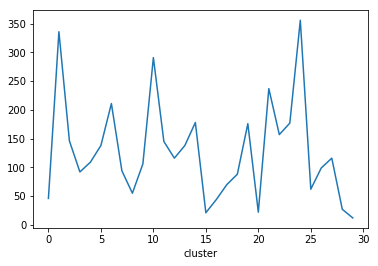

In [17]:
%%time
clusters = km.fit(right_neighbour_matrix)
cluster_s = pd.Series(clusters.labels_, index= change_df.index)
change_df["cluster"] = cluster_s
change_grouped_by_right = change_df.groupby("cluster")
change_grouped_by_right.size().plot()

In [18]:
change_grouped_by_right.get_group(2)[["left_string","del_string", "ins_string", "right_string"]].head(5)

left_string  \
1224855  2013-06-12T09:58:52Z 47         been in command . ref name   
14904681 2013-06-27T21:27:42Z 0       issue since of india ref name   
                              2                 }} / ref > ref name   
                              4                is not so . ref name   
                              6   incidents occurred in in ref name   

                                 del_string  ins_string  \
1224855  2013-06-12T09:58:52Z 47     mander  rajnayaran   
14904681 2013-06-27T21:27:42Z 0                       "   
                              2                       "   
                              4                       "   
                              6                       "   

                                                    right_string  
1224855  2013-06-12T09:58:52Z 47    > cite news last first title  
14904681 2013-06-27T21:27:42Z 0      > cite book last first paul  
                              2       > cite book last first ali  
                              4   > cite book last first stephen  
                              6     > cite book last first title

CPU times: user 1.12 s, sys: 168 ms, total: 1.28 s
Wall time: 4.71 s


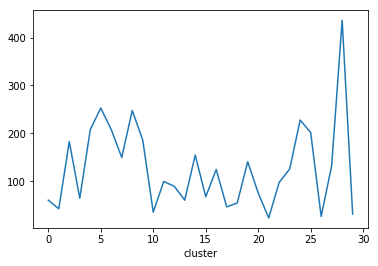

In [19]:
%%time
clusters = km.fit(left_neighbour_matrix)
cluster_s = pd.Series(clusters.labels_, index= change_df.index)
change_df["cluster"] = cluster_s
change_grouped_by_left = change_df.groupby("cluster")
change_grouped_by_left.size().plot()

In [20]:
change_grouped_by_left.get_group(1)[["left_string","del_string", "ins_string", "right_string"]].head(5)

left_string  \
4894531  2013-07-09T17:01:02Z 0   particular , organizations associated with the   
                              1   particular , organizations associated with the   
6060594  2013-07-18T02:03:38Z 0   particular , organizations associated with the   
         2013-07-18T02:05:46Z 3          was widespread support for the movement   
14904681 2013-08-17T15:42:44Z 27  particular , organizations associated with the   

                                             del_string ins_string  \
4894531  2013-07-09T17:01:02Z 0                                 [[   
                              1                                 ]]   
6060594  2013-07-18T02:03:38Z 0                 ( rss )              
         2013-07-18T02:05:46Z 3   although this support      which   
14904681 2013-08-17T15:42:44Z 27                                 ,   

                                                    right_string  
4894531  2013-07-09T17:01:02Z 0            ( ) such as the party  
                              1            ( ) such as the party  
6060594  2013-07-18T02:03:38Z 0            such as the party ( )  
         2013-07-18T02:05:46Z 3   off between and . the movement  
14904681 2013-08-17T15:42:44Z 27       such as the party , hindu

CPU times: user 1.6 s, sys: 532 ms, total: 2.13 s
Wall time: 10.8 s


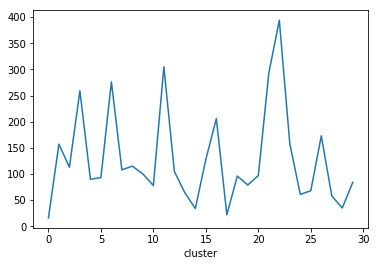

In [21]:
%%time
clusters = km.fit(neighbour_matrix)
cluster_s = pd.Series(clusters.labels_, index= change_df.index)
change_df["cluster"] = cluster_s
change_grouped_by_neigh = change_df.groupby("cluster")
change_grouped_by_neigh.size().plot()

In [22]:
change_grouped_by_neigh.get_group(2)[["left_string","del_string", "ins_string", "right_string"]].head(2)

left_string  \
1224855 2013-06-07T12:51:58Z 4  june }} date june }} }}   
                             6   / ref > since of india   

                                                                       del_string  \
1224855 2013-06-07T12:51:58Z 4  ' ' ' anti - muslim pogroms in india ' ' ' ref...   
                             6                    these pogroms have been endemic   

                               ins_string               right_string  
1224855 2013-06-07T12:51:58Z 4             ref name > cite book last  
                             6                 in india . ref name >

CPU times: user 924 ms, sys: 204 ms, total: 1.13 s
Wall time: 3.08 s


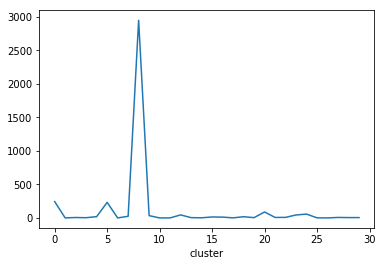

In [23]:
%%time
clusters = km.fit(ins_matrix)
cluster_s = pd.Series(clusters.labels_, index= change_df.index)
change_df["cluster"] = cluster_s
change_grouped_by_ins = change_df.groupby("cluster")
change_grouped_by_ins.size().plot()

In [24]:
change_grouped_by_ins.get_group(1)[["left_string","del_string", "ins_string", "right_string"]].tail(5)

,,,left_string,del_string,ins_string,right_string
0|183.82.173.219,2013-12-07T03:31:07Z,0,july }} violence against muslims }},,' ' ' anti - muslim violence in india ' ' ' ha...,references }} }} cite book last


In [25]:
change_grouped_by_left.get_group(2)[["left_string","del_string", "ins_string", "right_string"]].head(5)

left_string del_string  \
14904681 2013-06-03T14:57:37Z 0        }} / ref > references }}              
         2013-06-03T14:58:33Z 0  / ref > references }} category              
283225   2013-06-03T15:17:08Z 0                  r . }} / ref >              
17823581 2013-06-03T15:21:34Z 0       month february }} / ref >              
12160875 2013-06-04T05:01:29Z 0       month february }} / ref >              

                                                                        ins_string  \
14904681 2013-06-03T14:57:37Z 0                           [[ category : pogroms ]]   
         2013-06-03T14:58:33Z 0    [[ category : anti - muslim pogroms in india ]]   
283225   2013-06-03T15:17:08Z 0  since 1950 violent confrontations between hind...   
17823581 2013-06-03T15:21:34Z 0  according to [[ harsh mander ]] there is a con...   
12160875 2013-06-04T05:01:29Z 0  = = timeline = = = = 1960s = = = = = = gujarat...   

                                                     right_string  
14904681 2013-06-03T14:57:37Z 0                                    
         2013-06-03T14:58:33Z 0                                    
283225   2013-06-03T15:17:08Z 0  causes and effects has said that  
17823581 2013-06-03T15:21:34Z 0  after the violence in the indian  
12160875 2013-06-04T05:01:29Z 0     the has been described as one

CPU times: user 1.53 s, sys: 260 ms, total: 1.79 s
Wall time: 4.87 s


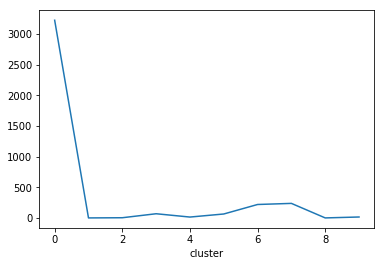

In [26]:
%%time
km = KMeans(n_clusters= 10, n_jobs=3)
clusters = km.fit(change_matrix)
cluster_s = pd.Series(clusters.labels_, index= change_df.index)
change_df["cluster"] = cluster_s
change_grouped_by_tokens = change_df.groupby("cluster")
change_grouped_by_tokens.size().plot()

In [27]:
change_grouped_by_tokens.size()

cluster
0    3227
1       2
2       5
3      70
4      16
5      66
6     221
7     239
8       2
9      17
dtype: int64

In [28]:
change_grouped_by_tokens.get_group(0)[["del_string", "ins_string"]].head(10)

del_string  \
14904681 2013-06-03T14:57:37Z 0              
         2013-06-03T14:58:33Z 0              
         2013-06-03T15:00:42Z 0              
         2013-06-03T15:03:34Z 0              
                              1              
                              2          -   
                              3  | pogroms   
                              4          ,   
                              5          ,   
                              6          ,   

                                                                      ins_string  
14904681 2013-06-03T14:57:37Z 0                         [[ category : pogroms ]]  
         2013-06-03T14:58:33Z 0  [[ category : anti - muslim pogroms in india ]]  
         2013-06-03T15:00:42Z 0                [[ category : ethnic cleansing ]]  
         2013-06-03T15:03:34Z 0                  {{ orphan | date = june 2013 }}  
                              1                                                s  
                              2                                                –  
                              3                                                   
                              4                                                   
                              5                                                   
                              6